# CAP 4453: Robot Vision Project

***Bryan Aneyro Hernandez***

This notebook covers both Part 1 (Neural Networks on MNIST) and Part 2 (Convolutional Neural Networks on CIFAR‑10).  

**Structure:**  
- **Part 1:** Three models for MNIST—(1) a simple network with no activations, (2) the same network with ReLU, and (3) a deep neural network.  
- **Part 2:** Two CNN models for CIFAR‑10—(1) CNN_Model1 (with experiments on different learning rates) , (2) CNN_Model2 (different filters, with experiments on varying epochs), and (3) CNN_Model3 ???? ***It wasn't in the pdf but it was in the sample code, so I did it just in case*** (one more conv2d layer with relu activation. Do not add maxpool after this new conv2d layer).

Simply run the cells in order.

In [ ]:
# Setup: Imports, device, and common utilities.
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

# Use GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Training function for fully connected networks.
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, flatten_input=False):
    model.train()
    train_loss_history = []
    test_accuracies = []
    start_time = time.time()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if flatten_input and len(inputs.shape) > 2:
                inputs = inputs.view(inputs.size(0), -1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()* inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        _, acc = test_model(model, test_loader, criterion, flatten_input=True)
        test_accuracies.append(acc)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Test Acc: {acc:.2f}%")
    training_time = time.time() - start_time
    return train_loss_history, training_time, test_accuracies

# Testing function.
def test_model(model, test_loader, criterion, flatten_input=False):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if flatten_input and len(inputs.shape) > 2:
                inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(test_loader.dataset)
    accuracy = correct / total * 100
    return avg_loss, accuracy

# Simple utility for plotting loss curves.
def plot_loss_curve(loss_history, title="Training Loss"):
    plt.figure(figsize=(6,4))
    plt.plot(loss_history, marker='o')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

def plot_accuracy_curve(accuracies, title="Training Accuracies"):
    plt.figure(figsize=(10,4))
    for l_rate in learning_rates:
        plt.plot(accuracies, marker='o')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.show()

# Enhanced visualization function.
def visualize_predictions(model, test_loader, num_images=8, flatten_input=False, unnormalize=False, dataset_type=None, class_names=None):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    if flatten_input and len(images.shape) > 2:
        inputs = images.view(images.size(0), -1)
    else:
        inputs = images
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    images = images.cpu().numpy()

    plt.figure(figsize=(15, 4))
    for idx in range(num_images):
        plt.subplot(1, num_images, idx+1)
        img = images[idx]
        if unnormalize:
            # For CIFAR-10 normalization (mean 0.5, std 0.5)
            img = img * 0.5 + 0.5
        if img.shape[0] == 1:
            plt.imshow(np.squeeze(img), cmap='gray')
        else:
            img = np.transpose(img, (1, 2, 0))
            plt.imshow(np.clip(img, 0, 1))
        # Set title: if a dataset type is provided and equals 'cifar', use class_names.
        if dataset_type == 'cifar' and class_names is not None:
            plt.title(f"Pred: {class_names[preds[idx].item()]}", fontsize=10)
        else:
            plt.title(f"Pred: {preds[idx].item()}", fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

Using device: cuda


## Part 1: Neural Networks on MNIST

In this section we train three models on MNIST:
1. **SimpleNNNoActivation:** A simple 3-layer network with no activation functions.
2. **SimpleNNReLU:** The same network with ReLU activations.
3. **DeepNN:** A deeper network with multiple hidden layers.

In [ ]:
# Define MNIST models.

# Task 1: SimpleNNNoActivation (no activation functions)
class SimpleNNNoActivation(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=10, num_classes=10):
        super(SimpleNNNoActivation, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)    # Layer 1
        self.fc2 = nn.Linear(hidden_size, hidden_size)   # Layer 2
        self.fc3 = nn.Linear(hidden_size, num_classes)   # Layer 3

    def forward(self, x):
        # x is already flattened by train_model(flatten_input=True)
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

# Task 2: SimpleNNReLU (with ReLU activation)
class SimpleNNReLU(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=10, num_classes=10):
        super(SimpleNNReLU, self).__init__()
        self.fc1  = nn.Linear(input_size, hidden_size)   # Layer 1
        self.relu = nn.ReLU()
        self.fc2  = nn.Linear(hidden_size, hidden_size)  # Layer 2
        self.fc3  = nn.Linear(hidden_size, num_classes)  # Layer 3

    def forward(self, x):
        # x is already flattened by train_model(flatten_input=True)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

# Task 3: DeepNN (a deep network with 5 hidden layers)
class DeepNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=300, num_classes=10, num_hidden_layers=5):
        super(DeepNN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, num_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        # x is already flattened by train_model(flatten_input=True)
        return self.net(x)

### MNIST Data Loading

In [ ]:
# MNIST transforms and loaders.
transform_mnist = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))])
batch_size = 32
train_dataset_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
test_dataset_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
train_loader_mnist = torch.utils.data.DataLoader(train_dataset_mnist, batch_size=batch_size, shuffle=True)
test_loader_mnist = torch.utils.data.DataLoader(test_dataset_mnist, batch_size=batch_size, shuffle=False)

### Training and Evaluation on MNIST

In [ ]:
# Define loss function.
criterion = nn.CrossEntropyLoss()

Training Task 1: Simple NN (No Activation) LR=(0.1)
Epoch [1/20], Loss: 0.4301, Test Acc: 89.47%
Epoch [2/20], Loss: 0.3581, Test Acc: 90.77%
Epoch [3/20], Loss: 0.3491, Test Acc: 87.95%
Epoch [4/20], Loss: 0.3421, Test Acc: 90.91%
Epoch [5/20], Loss: 0.3420, Test Acc: 90.56%
Epoch [6/20], Loss: 0.3376, Test Acc: 89.07%
Epoch [7/20], Loss: 0.3326, Test Acc: 91.36%
Epoch [8/20], Loss: 0.3316, Test Acc: 90.82%
Epoch [9/20], Loss: 0.3328, Test Acc: 90.65%
Epoch [10/20], Loss: 0.3303, Test Acc: 91.34%
Epoch [11/20], Loss: 0.3317, Test Acc: 90.89%
Epoch [12/20], Loss: 0.3290, Test Acc: 90.20%
Epoch [13/20], Loss: 0.3283, Test Acc: 90.59%
Epoch [14/20], Loss: 0.3272, Test Acc: 90.50%
Epoch [15/20], Loss: 0.3269, Test Acc: 91.10%
Epoch [16/20], Loss: 0.3268, Test Acc: 91.04%
Epoch [17/20], Loss: 0.3260, Test Acc: 90.87%
Epoch [18/20], Loss: 0.3252, Test Acc: 90.57%
Epoch [19/20], Loss: 0.3249, Test Acc: 90.75%
Epoch [20/20], Loss: 0.3260, Test Acc: 90.38%
Training time: 317.79 seconds
Test Lo

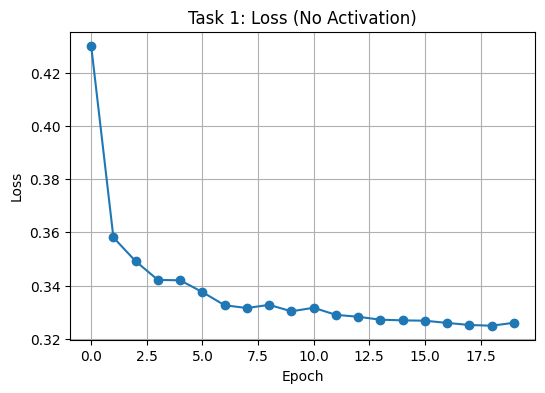

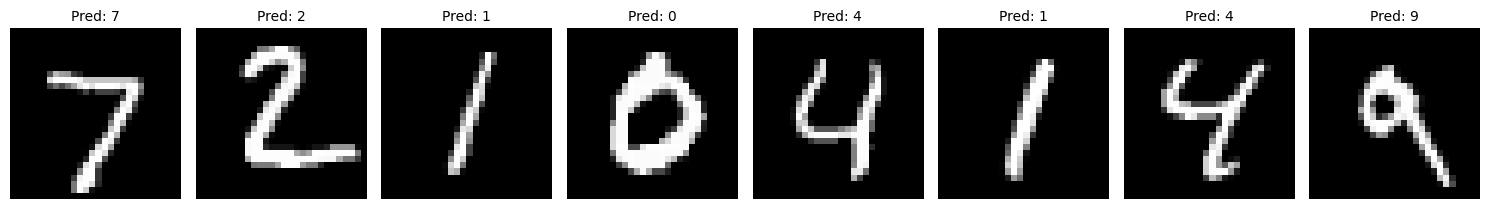

In [ ]:
# --- Task 1: SimpleNNNoActivation ---
model1 = SimpleNNNoActivation().to(device)
optimizer1 = optim.SGD(model1.parameters(), lr=0.1)
print("Training Task 1: Simple NN (No Activation) LR=(0.1)")
loss_history1, train_time1, accuracies = train_model(model1, train_loader_mnist, test_loader_mnist, criterion, optimizer1, num_epochs=20, flatten_input=True)
print(f"Training time: {train_time1:.2f} seconds")
test_loss1, test_accuracy1 = test_model(model1, test_loader_mnist, criterion, flatten_input=True)
print(f"Test Loss: {test_loss1:.4f}, Test Accuracy: {test_accuracy1:.2f}%")
plot_loss_curve(loss_history1, title="Task 1: Loss (No Activation)")
visualize_predictions(model1, test_loader_mnist, num_images=8, flatten_input=True, unnormalize=False)

**Observation (Task 1):**  
The loss decreases steadily and the simple network reaches a baseline accuracy, though its linear nature limits performance.


Training Task 2: NN with ReLU Activation LR=(0.1)
Epoch [1/20], Loss: 0.4611, Test Acc: 90.94%
Epoch [2/20], Loss: 0.2989, Test Acc: 93.12%
Epoch [3/20], Loss: 0.2678, Test Acc: 92.84%
Epoch [4/20], Loss: 0.2492, Test Acc: 93.49%
Epoch [5/20], Loss: 0.2356, Test Acc: 92.89%
Epoch [6/20], Loss: 0.2290, Test Acc: 93.50%
Epoch [7/20], Loss: 0.2218, Test Acc: 93.11%
Epoch [8/20], Loss: 0.2155, Test Acc: 93.33%
Epoch [9/20], Loss: 0.2126, Test Acc: 92.58%
Epoch [10/20], Loss: 0.2131, Test Acc: 93.33%
Epoch [11/20], Loss: 0.2087, Test Acc: 93.89%
Epoch [12/20], Loss: 0.2047, Test Acc: 93.39%
Epoch [13/20], Loss: 0.2033, Test Acc: 93.62%
Epoch [14/20], Loss: 0.2021, Test Acc: 92.67%
Epoch [15/20], Loss: 0.2008, Test Acc: 93.44%
Epoch [16/20], Loss: 0.1961, Test Acc: 93.63%
Epoch [17/20], Loss: 0.1972, Test Acc: 93.54%
Epoch [18/20], Loss: 0.1980, Test Acc: 93.56%
Epoch [19/20], Loss: 0.1934, Test Acc: 93.88%
Epoch [20/20], Loss: 0.1928, Test Acc: 93.48%
Training time: 324.24 seconds
Test Los

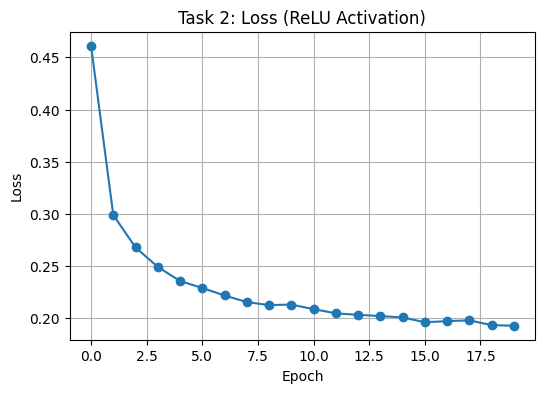

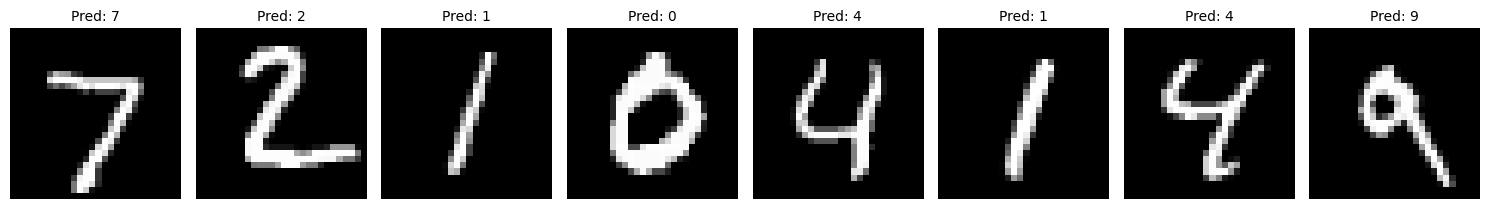

In [ ]:
# --- Task 2: SimpleNNReLU ---
model2 = SimpleNNReLU().to(device)
optimizer2 = optim.SGD(model2.parameters(), lr=0.1)
print("\nTraining Task 2: NN with ReLU Activation LR=(0.1)")
loss_history2, train_time2, accuracies2 = train_model(model2, train_loader_mnist, test_loader_mnist, criterion, optimizer2, num_epochs=20, flatten_input=True)
print(f"Training time: {train_time2:.2f} seconds")
test_loss2, test_accuracy2 = test_model(model2, test_loader_mnist, criterion, flatten_input=True)
print(f"Test Loss: {test_loss2:.4f}, Test Accuracy: {test_accuracy2:.2f}%")
plot_loss_curve(loss_history2, title="Task 2: Loss (ReLU Activation)")
visualize_predictions(model2, test_loader_mnist, num_images=8, flatten_input=True, unnormalize=False)

**Observation (Task 2):**  
With ReLU activations the network converges faster and reaches higher accuracy due to enhanced non-linear feature extraction.


Training Task 3: Deep Neural Network LR=(0.1)
Epoch [1/20], Loss: 0.4192, Test Acc: 95.26%
Epoch [2/20], Loss: 0.1072, Test Acc: 95.59%
Epoch [3/20], Loss: 0.0726, Test Acc: 97.71%
Epoch [4/20], Loss: 0.0543, Test Acc: 97.92%
Epoch [5/20], Loss: 0.0407, Test Acc: 98.00%
Epoch [6/20], Loss: 0.0330, Test Acc: 98.07%
Epoch [7/20], Loss: 0.0251, Test Acc: 97.72%
Epoch [8/20], Loss: 0.0203, Test Acc: 98.25%
Epoch [9/20], Loss: 0.0176, Test Acc: 97.45%
Epoch [10/20], Loss: 0.0170, Test Acc: 98.18%
Epoch [11/20], Loss: 0.0140, Test Acc: 98.05%
Epoch [12/20], Loss: 0.0145, Test Acc: 98.21%
Epoch [13/20], Loss: 0.0107, Test Acc: 98.12%
Epoch [14/20], Loss: 0.0090, Test Acc: 98.15%
Epoch [15/20], Loss: 0.0095, Test Acc: 98.06%
Epoch [16/20], Loss: 0.0059, Test Acc: 98.22%
Epoch [17/20], Loss: 0.0051, Test Acc: 98.03%
Epoch [18/20], Loss: 0.0052, Test Acc: 98.37%
Epoch [19/20], Loss: 0.0070, Test Acc: 98.01%
Epoch [20/20], Loss: 0.0064, Test Acc: 98.36%
Training time: 351.63 seconds
Test Loss: 0

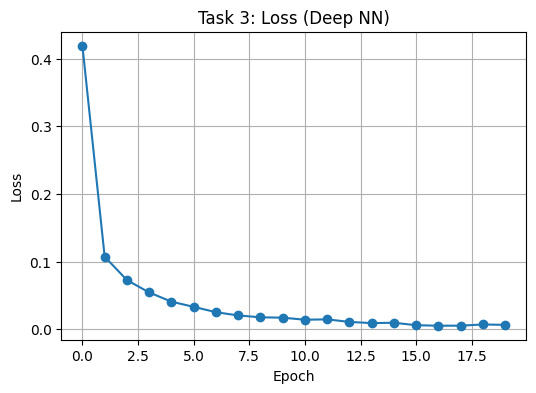

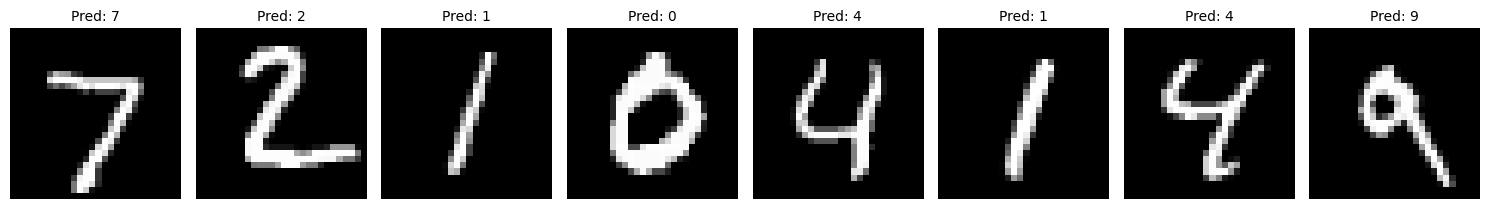

In [ ]:
# --- Task 3: DeepNN ---
model3 = DeepNN().to(device)
optimizer3 = optim.SGD(model3.parameters(), lr=0.1)
print("\nTraining Task 3: Deep Neural Network LR=(0.1)")
loss_history3, train_time3, accuracies3 = train_model(model3, train_loader_mnist, test_loader_mnist, criterion, optimizer3, num_epochs=20, flatten_input=True)
print(f"Training time: {train_time3:.2f} seconds")
test_loss3, test_accuracy3 = test_model(model3, test_loader_mnist, criterion, flatten_input=True)
print(f"Test Loss: {test_loss3:.4f}, Test Accuracy: {test_accuracy3:.2f}%")
plot_loss_curve(loss_history3, title="Task 3: Loss (Deep NN)")
visualize_predictions(model3, test_loader_mnist, num_images=8, flatten_input=True, unnormalize=False)

**Observation (Task 3):**  
The deep network achieves higher accuracy by learning complex, hierarchical features, though it requires longer training and careful tuning.

## Part 2: Convolutional Neural Networks on CIFAR‑10

In this section we test two CNN architectures on CIFAR‑10:

- **CNN_Model1:** Experimented with different learning rates (0.5, 0.1, 0.01).
- **CNN_Model2:** Increased filters version with experiments on different training durations (10, 20, 30 epochs).

The CIFAR‑10 classes are defined as follows.

In [ ]:
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

### CIFAR‑10 Data Loading

In [ ]:
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size_cifar = 32
train_dataset_cifar = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
test_dataset_cifar = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
train_loader_cifar = torch.utils.data.DataLoader(train_dataset_cifar, batch_size=batch_size_cifar, shuffle=True)
test_loader_cifar = torch.utils.data.DataLoader(test_dataset_cifar, batch_size=batch_size_cifar, shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


### Define CIFAR‑10 CNN Models

In [ ]:
import torch.nn as nn

# Task 4: CNN_Model1 with 2 Conv+Pool layers and 2 FC layers
class CNN_Model1(nn.Module):
    def __init__(self):
        super(CNN_Model1, self).__init__()
        # Convolutional blocks
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3)
        self.relu  = nn.ReLU()
        self.pool  = nn.MaxPool2d(kernel_size=2)

        # Fully‑connected blocks (360 → 128 → 10)
        self.fc1 = nn.Linear(360, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Conv→ReLU→Pool
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # FC→ReLU→FC
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Task 5: CNN_Model2 with increased filters and 2 FC layers
class CNN_Model2(nn.Module):
    def __init__(self):
        super(CNN_Model2, self).__init__()
        # Convolutional blocks
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3)
        self.relu  = nn.ReLU()
        self.pool  = nn.MaxPool2d(kernel_size=2)

        # Fully‑connected blocks (1440 → 128 → 10)
        self.fc1 = nn.Linear(1440, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Conv→ReLU→Pool
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # FC→ReLU→FC
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Task 6?????? It wasn't in the pdf but it was in the sample code, so I did it just in case
class CNN_Model3(nn.Module):
    def __init__(self):
        super(CNN_Model3, self).__init__()
        # Convolutional blocks (like Model2, then one extra conv)
        self.conv1 = nn.Conv2d(in_channels=3,  out_channels=20, kernel_size=3)  # 32→30
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3)  # 15→13
        self.conv3 = nn.Conv2d(in_channels=40, out_channels=80, kernel_size=3)  # 6→4
        self.relu  = nn.ReLU()
        self.pool  = nn.MaxPool2d(kernel_size=2)

        # After conv1+pool, conv2+pool, conv3:
        #   32→30→15→13→6→4, channels=80 → 80×4×4 = 1280 features
        self.fc1 = nn.Linear(1280, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Conv→ReLU→Pool (first block)
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        # Conv→ReLU→Pool (second block)
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Conv→ReLU (third block, no pooling)
        x = self.relu(self.conv3(x))

        # Flatten
        x = x.view(x.size(0), -1)  # (batch, 1280)

        # FC→ReLU→FC
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x



### Training Functions for CIFAR‑10 CNN Models

We define separate training routines for CNN_Model1 and CNN_Model2.

In [ ]:
# Define loss function.
criterion_cifar = nn.CrossEntropyLoss()

In [ ]:
def train_cnn_model(model, train_loader, test_loader, criterion, learning_rate, num_epochs):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    train_losses = []
    test_accuracies = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        _, acc = test_model(model, test_loader, criterion, flatten_input=False)
        test_accuracies.append(acc)
        print(f"LR {learning_rate}, Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Test Acc: {acc:.2f}%")
    return train_losses, test_accuracies

def train_cnn_model2(model, num_epochs, learning_rate, train_loader, test_loader, criterion):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    train_losses = []
    test_accuracies = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        _, acc = test_model(model, test_loader, criterion, flatten_input=False)
        test_accuracies.append(acc)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Test Acc: {acc:.2f}%")
    return train_losses, test_accuracies

### Task 4: Experiments with CNN_Model1 (Varying Learning Rates)

We test three learning rates: 0.5, 0.1, and 0.01.


Training CNN_Model1 with learning rate 0.5
LR 0.5, Epoch [1/10], Loss: 1.9354, Test Acc: 28.57%
LR 0.5, Epoch [2/10], Loss: 1.7542, Test Acc: 35.96%
LR 0.5, Epoch [3/10], Loss: 1.7085, Test Acc: 38.10%
LR 0.5, Epoch [4/10], Loss: 1.6733, Test Acc: 27.38%
LR 0.5, Epoch [5/10], Loss: 1.6551, Test Acc: 42.41%
LR 0.5, Epoch [6/10], Loss: 1.6342, Test Acc: 41.23%
LR 0.5, Epoch [7/10], Loss: 1.6117, Test Acc: 43.21%
LR 0.5, Epoch [8/10], Loss: 1.6025, Test Acc: 42.87%
LR 0.5, Epoch [9/10], Loss: 1.5805, Test Acc: 42.12%
LR 0.5, Epoch [10/10], Loss: 1.5896, Test Acc: 41.12%

Training CNN_Model1 with learning rate 0.1
LR 0.1, Epoch [1/10], Loss: 1.6322, Test Acc: 51.10%
LR 0.1, Epoch [2/10], Loss: 1.3032, Test Acc: 51.13%
LR 0.1, Epoch [3/10], Loss: 1.1705, Test Acc: 56.08%
LR 0.1, Epoch [4/10], Loss: 1.0835, Test Acc: 56.90%
LR 0.1, Epoch [5/10], Loss: 1.0120, Test Acc: 60.97%
LR 0.1, Epoch [6/10], Loss: 0.9630, Test Acc: 61.71%
LR 0.1, Epoch [7/10], Loss: 0.9189, Test Acc: 62.18%
LR 0.1, Ep

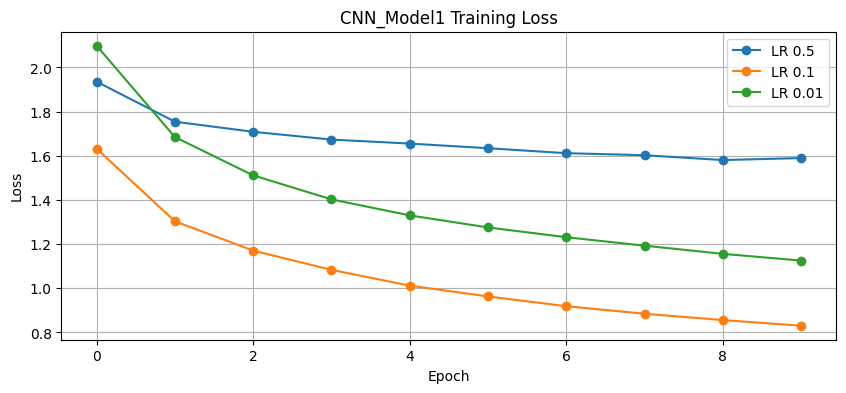

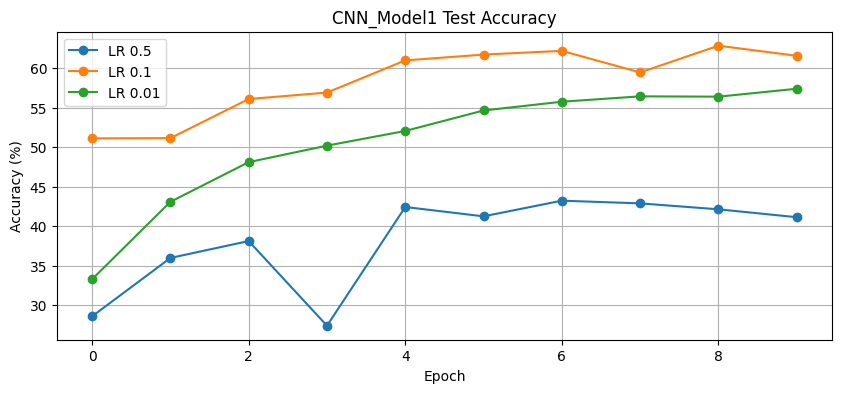

Visualizing predictions for CNN_Model1 (LR=0.1)


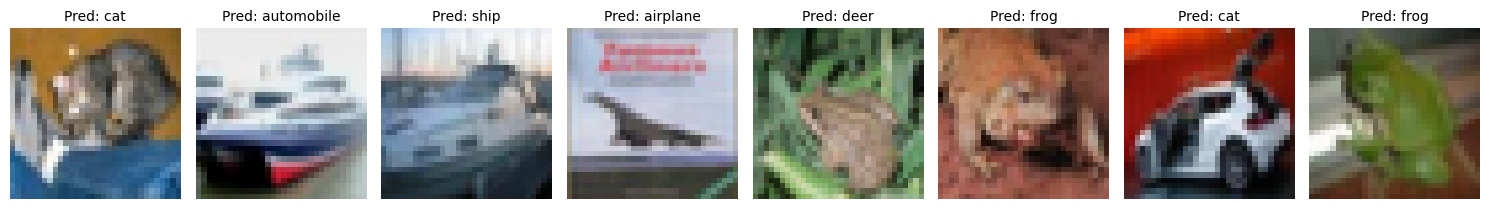

In [ ]:
learning_rates = [0.5, 0.1, 0.01]
results_cnn1 = {}
num_epochs = 10
# criterion_cifar = nn.CrossEntropyLoss()

# Test model
for lr in learning_rates:
    print(f"\nTraining CNN_Model1 with learning rate {lr}")
    model_cnn1 = CNN_Model1().to(device)
    losses, accuracies = train_cnn_model(model_cnn1, train_loader_cifar, test_loader_cifar, criterion_cifar, learning_rate=lr, num_epochs=num_epochs)
    results_cnn1[lr] = {"losses": losses, "accuracies": accuracies}

# Plot results for CNN_Model1 (example for LR=0.1)
plt.figure(figsize=(10,4))
for l_rate in learning_rates:
  plt.plot(results_cnn1[l_rate]["losses"], marker='o', label=f"LR {l_rate}")
plt.title("CNN_Model1 Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
for l_rate in learning_rates:
    plt.plot(results_cnn1[l_rate]["accuracies"], marker='o', label=f"LR {l_rate}")
plt.title("CNN_Model1 Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

print("Visualizing predictions for CNN_Model1 (LR=0.1)")
visualize_predictions(model_cnn1, test_loader_cifar, num_images=8, flatten_input=False, unnormalize=True, dataset_type='cifar', class_names=CIFAR10_CLASSES)

**Observation (Task 4):**  
A high learning rate (0.5) yields poor accuracy while both 0.1 and 0.01 provide better, more stable convergence—with 0.1 converging faster and reaching about 60-62% test accuracy.

### Task 5: Experiments with CNN_Model2 (Varying Epochs)

We train CNN_Model2 using LR=0.1 for 10, 20, and 30 epochs.


Training CNN_Model2 for 10 epochs (LR=0.1)
Epoch [1/10], Loss: 1.5132, Test Acc: 47.07%
Epoch [2/10], Loss: 1.0851, Test Acc: 64.76%
Epoch [3/10], Loss: 0.9069, Test Acc: 63.59%
Epoch [4/10], Loss: 0.7769, Test Acc: 65.83%
Epoch [5/10], Loss: 0.6741, Test Acc: 63.18%
Epoch [6/10], Loss: 0.5850, Test Acc: 68.48%
Epoch [7/10], Loss: 0.5057, Test Acc: 68.25%
Epoch [8/10], Loss: 0.4366, Test Acc: 62.77%
Epoch [9/10], Loss: 0.3829, Test Acc: 67.04%
Epoch [10/10], Loss: 0.3392, Test Acc: 66.59%

Training CNN_Model2 for 20 epochs (LR=0.1)
Epoch [1/20], Loss: 1.5093, Test Acc: 54.78%
Epoch [2/20], Loss: 1.1139, Test Acc: 63.91%
Epoch [3/20], Loss: 0.9289, Test Acc: 63.92%
Epoch [4/20], Loss: 0.7937, Test Acc: 65.48%
Epoch [5/20], Loss: 0.6919, Test Acc: 69.15%
Epoch [6/20], Loss: 0.6003, Test Acc: 67.81%
Epoch [7/20], Loss: 0.5191, Test Acc: 67.69%
Epoch [8/20], Loss: 0.4475, Test Acc: 65.35%
Epoch [9/20], Loss: 0.3953, Test Acc: 67.29%
Epoch [10/20], Loss: 0.3516, Test Acc: 66.70%
Epoch [11/

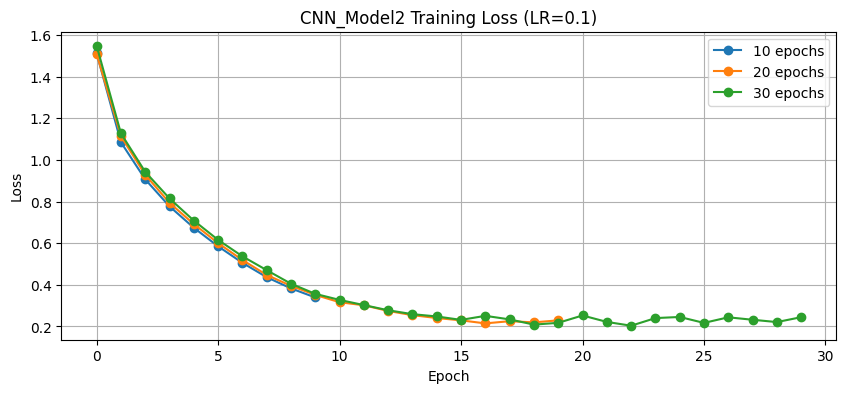

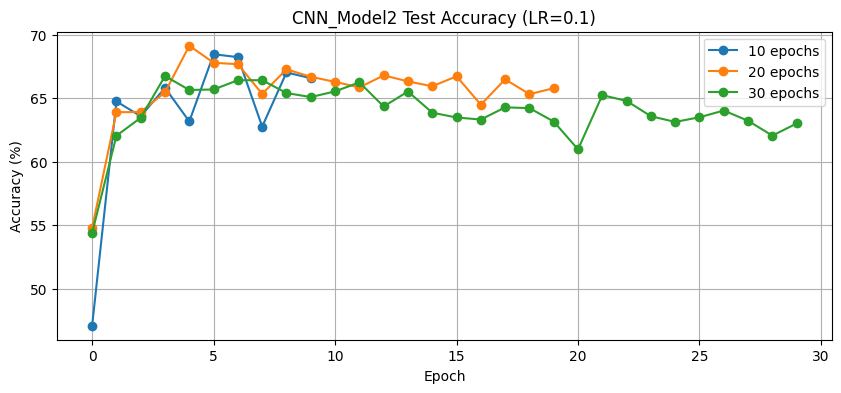

Visualizing predictions for CNN_Model2


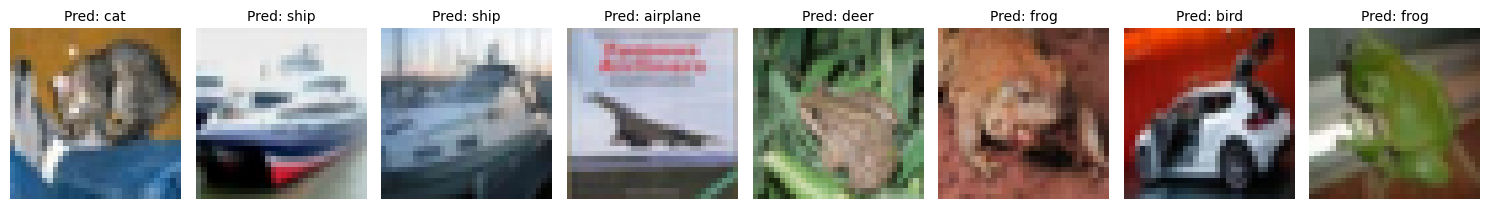

In [ ]:
epochs_list = [10, 20, 30]
results_cnn2 = {}

# Test model
for num_epochs in epochs_list:
    print(f"\nTraining CNN_Model2 for {num_epochs} epochs (LR=0.1)")
    model_cnn2 = CNN_Model2().to(device)
    losses2, accuracies2 = train_cnn_model2(model_cnn2, num_epochs=num_epochs, learning_rate=0.1,
                                            train_loader=train_loader_cifar, test_loader=test_loader_cifar,
                                            criterion=criterion_cifar)
    results_cnn2[num_epochs] = {"losses": losses2, "accuracies": accuracies2}

# Plot training loss for CNN_Model2.
plt.figure(figsize=(10,4))
for num_epochs in epochs_list:
    plt.plot(results_cnn2[num_epochs]["losses"], marker='o', label=f"{num_epochs} epochs")
plt.title("CNN_Model2 Training Loss (LR=0.1)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot test accuracy for CNN_Model2.
plt.figure(figsize=(10,4))
for num_epochs in epochs_list:
    plt.plot(results_cnn2[num_epochs]["accuracies"], marker='o', label=f"{num_epochs} epochs")
plt.title("CNN_Model2 Test Accuracy (LR=0.1)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

print("Visualizing predictions for CNN_Model2")
visualize_predictions(model_cnn2, test_loader_cifar, num_images=8, flatten_input=False, unnormalize=True, dataset_type='cifar', class_names=CIFAR10_CLASSES)

**Observation (Task 5):**  
CNN_Model2 reaches test accuracies around 64–67% when trained for 10 epochs, with training for 20 epochs yielding more stable performance. Training for 30 epochs shows minimal or no further gains, indicating diminishing improvements with extended training.

### Task 6?????: Experiments with CNN_Model3 (Varying Epochs)

***It wasn't in the pdf but it was in the sample code, so I did it just in case.***

We train CNN_Model3 using LR=0.1 for 10, 20, and 30 epochs.


Training CNN_Model3 for 10 epochs (LR=0.1)
Epoch [1/10], Loss: 1.5156, Test Acc: 51.81%
Epoch [2/10], Loss: 1.1047, Test Acc: 59.99%
Epoch [3/10], Loss: 0.9269, Test Acc: 57.43%
Epoch [4/10], Loss: 0.8053, Test Acc: 63.14%
Epoch [5/10], Loss: 0.7024, Test Acc: 65.42%
Epoch [6/10], Loss: 0.6114, Test Acc: 67.15%
Epoch [7/10], Loss: 0.5314, Test Acc: 68.09%
Epoch [8/10], Loss: 0.4682, Test Acc: 68.05%
Epoch [9/10], Loss: 0.4043, Test Acc: 67.02%
Epoch [10/10], Loss: 0.3617, Test Acc: 66.24%

Training CNN_Model3 for 20 epochs (LR=0.1)
Epoch [1/20], Loss: 1.5237, Test Acc: 54.54%
Epoch [2/20], Loss: 1.1025, Test Acc: 62.63%
Epoch [3/20], Loss: 0.9196, Test Acc: 66.64%
Epoch [4/20], Loss: 0.7895, Test Acc: 68.41%
Epoch [5/20], Loss: 0.6816, Test Acc: 63.78%
Epoch [6/20], Loss: 0.5981, Test Acc: 64.26%
Epoch [7/20], Loss: 0.5173, Test Acc: 67.24%
Epoch [8/20], Loss: 0.4503, Test Acc: 68.21%
Epoch [9/20], Loss: 0.3964, Test Acc: 64.64%
Epoch [10/20], Loss: 0.3482, Test Acc: 67.19%
Epoch [11/

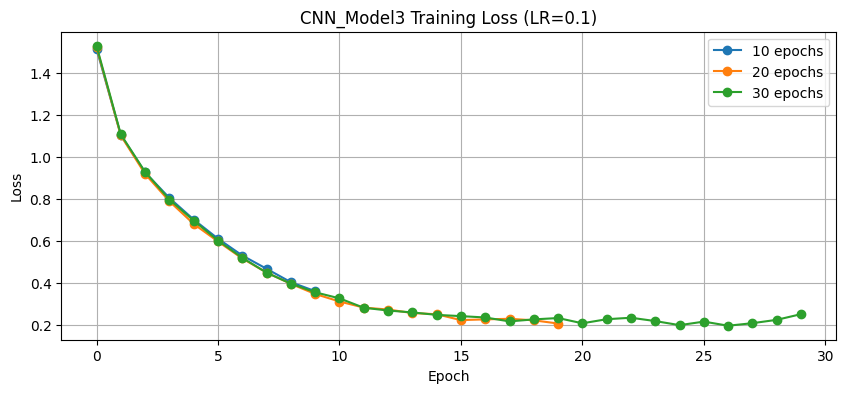

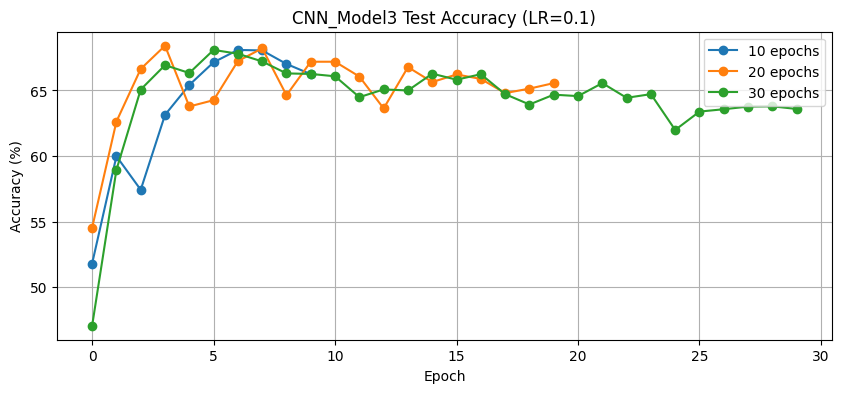

Visualizing predictions for CNN_Model2


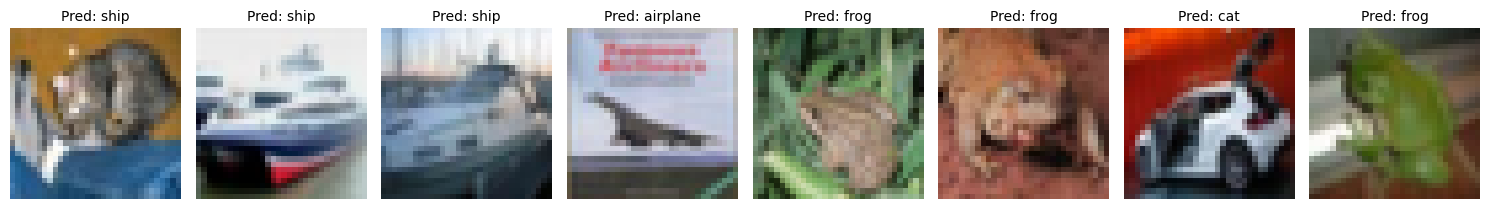

In [ ]:
epochs_list = [10, 20, 30]
results_cnn3 = {}

# Test model
for num_epochs in epochs_list:
    print(f"\nTraining CNN_Model3 for {num_epochs} epochs (LR=0.1)")
    model_cnn3 = CNN_Model2().to(device)
    losses2, accuracies2 = train_cnn_model2(model_cnn3, num_epochs=num_epochs, learning_rate=0.1,
                                            train_loader=train_loader_cifar, test_loader=test_loader_cifar,
                                            criterion=criterion_cifar)
    results_cnn3[num_epochs] = {"losses": losses2, "accuracies": accuracies2}

# Plot training loss for CNN_Model3.
plt.figure(figsize=(10,4))
for num_epochs in epochs_list:
    plt.plot(results_cnn3[num_epochs]["losses"], marker='o', label=f"{num_epochs} epochs")
plt.title("CNN_Model3 Training Loss (LR=0.1)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot test accuracy for CNN_Model3.
plt.figure(figsize=(10,4))
for num_epochs in epochs_list:
    plt.plot(results_cnn3[num_epochs]["accuracies"], marker='o', label=f"{num_epochs} epochs")
plt.title("CNN_Model3 Test Accuracy (LR=0.1)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

print("Visualizing predictions for CNN_Model2")
visualize_predictions(model_cnn3, test_loader_cifar, num_images=8, flatten_input=False, unnormalize=True, dataset_type='cifar', class_names=CIFAR10_CLASSES)

**Observation (Task 6):**  
CNN_Model3 reaches test accuracies around 64–67% when trained for 10 epochs, with training for 20 epochs yielding more stable performance. Training for 30 epochs shows minimal or no further gains, indicating diminishing improvements with extended training.***(Around the same as task 5)***